## Setup

In [64]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

def func1(x:float):
    return x**2-4*x+1

def gradient_func1(x:float):
    return 2*x - 4

def func2(x:float):
    return 0.01*x**4-3*x**2+5*x+350

def gradient_func2(x:float):
    return 0.04*x**3-6*x+5

def random_initialize():
    x = randint(-20, 20)
    return x

def build_function1():
    x = np.arange(-20., 20., 0.2)
    y = np.array([func1(val) for val in x])
    return x,y, func1, gradient_func1

def build_function2():
    x = np.arange(-20., 20., 0.2)
    y = np.array([func2(val) for val in x])
    return x,y, func2, gradient_func2

## Regular Gradient Descent

$$
\theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta)
$$

In [65]:
def step(x,r, grad):
    x = x - r * grad(x)
    return x

def gradient_descent(function=build_function1,steps=10, r=0.1, print_res=False, initalRandom=False, initalX=10 ): # initalX is chosen as a starting coordinate when initalRandom is False
    x,y, f, grad_f = function()
    plt.plot(x,y)
    
    if initalRandom:
        cur_x = random_initialize()
    else:
        cur_x = initalX
    
    for i in range(steps):
        cur_y = f(cur_x)
        plt.plot(cur_x, cur_y, color='red', marker='o')
        cur_x = step(cur_x, r, grad_f)
        if print_res:
            print("Step" + str(i) + " : X = " + str(cur_x) + ", Y= " + str(cur_y))

    plt.xlim(-20, 20)
    plt.ylim(-20,500)
    plt.grid()
    plt.show()

lr_slider = widgets.FloatSlider(min=0,max=2,step=0.01, description="Learning Rate")
steps_slider = widgets.IntSlider(min=1,max=30,step=1, description="Steps")
func_dropdown = widgets.Dropdown(description="Function", options=[build_function1, build_function2])
x_slider = widgets.IntSlider(min=-20,max=20, step=1, description="Starting Point")

ui = widgets.HBox([x_slider, lr_slider, steps_slider, func_dropdown])

out = widgets.interactive_output(gradient_descent, {'initalX': x_slider, 'r': lr_slider, 'steps': steps_slider, 'function': func_dropdown})##
display(out, ui)

Output()

## Momentum Optimization

$$
m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta) \\
\theta \leftarrow \theta + m
$$

In [66]:
def momentum_step(x,lr,beta,momentum, grad):
    m = beta*momentum - lr * grad(x)
    x = x + m
    return m,x

def momentum_gradient_descent(function=build_function1,steps=10, lr=0.1, beta=0.1, print_res=False, initalRandom=True, initalX=10): # initalX is chosen as a starting coordinate when initalRandom is False
    x,y, f, grad = function()
    plt.plot(x,y)
    if initalRandom:
        cur_x = random_initialize()
    else:
        cur_x = initalX
    
    momentum = 0
    for i in range(steps):
        cur_y = f(cur_x)
        plt.plot(cur_x, cur_y, color='red', marker='o')
        momentum, cur_x = momentum_step(cur_x, lr, beta, momentum, grad)
        if print_res:
            print("Step" + str(i) + " : X = " + str(cur_x) + ", Y= " + str(cur_y))

    plt.grid()
    plt.show()

lr_slider = widgets.FloatSlider(min=0,max=2,step=0.01, description="Learning Rate")
steps_slider = widgets.IntSlider(min=1,max=30,step=1, description="Steps")
func_dropdown = widgets.Dropdown(description="Function", options=[build_function1, build_function2])
x_slider = widgets.IntSlider(min=-20,max=20, step=1, description="Starting Point")

ui = widgets.HBox([x_slider, lr_slider, steps_slider, func_dropdown])

out = widgets.interactive_output(gradient_descent, {'initalX': x_slider, 'r': lr_slider, 'steps': steps_slider, 'function': func_dropdown})##
display(out, ui)

#momentum_gradient_descent(steps=30, lr=0.05, beta=0.6)


Output()

## Comparision

Regular Gradient-Descent


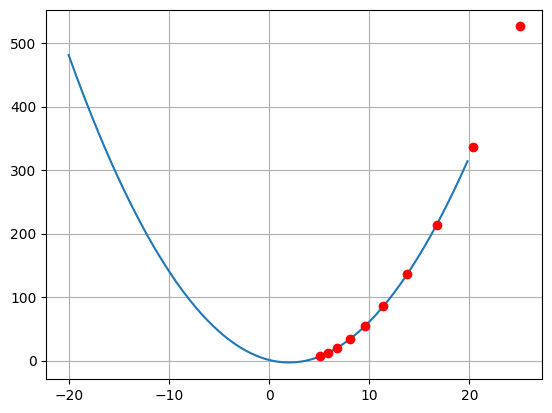

Momentum Optimization


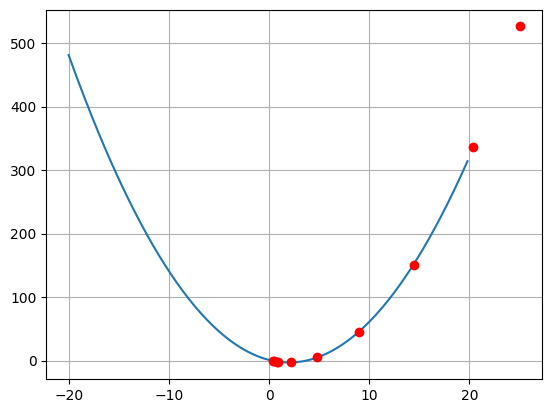

In [27]:
print("Regular Gradient-Descent")
gradient_descent(steps=10, initalRandom=False, initalX=25, print_res=False)
print("Momentum Optimization")
momentum_gradient_descent(steps=10,beta=0.5, initalRandom=False, initalX=25, print_res=False)
